In [1]:
#from data import CocoDatasetManager
from collections import Counter
from backbone import ClassificationRCNN
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt


In [2]:
# Check if CUDA (GPU support) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading the dataset

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #imagenet transformation
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/validation', transform=transform)

'''
# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))  # 80% of the dataset
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
'''

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [4]:
print("Number of training Images: ", len(train_dataset))
print("Number of test_loader: ", len(test_dataset))

Number of training Images:  9372
Number of test_loader:  4952


## Loading the model

In [18]:

model = ClassificationRCNN(num_classes=78)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
model = ClassificationRCNN(num_classes=78)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


/home/amanandhar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amanandhar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model = model.to(device)  # Move the model to GPU

In [8]:
model

ClassificationRCNN(
  (resnet_backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

## Training the model

In [9]:
num_epochs = 20
loss_graph = []
accuracy_graph = []
validation_loss=[]

print(f"Starting training for {num_epochs} epochs.")

for epoch in range(num_epochs):
    model.train() 
    print(f"Epoch {epoch+1} started.")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        try:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0: 
                loss_value = loss.item()
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i}, Loss: {loss_value:.4f}")

        except Exception as e:
            print(f"An error occurred: {e}")
    loss_graph.append(loss_value)

    # Validation phase
    model.eval()  
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    accuracy_graph.append(accuracy)
    validation_loss.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Training Loss: {loss.item():.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')


Starting training for 20 epochs.
Epoch 1 started.
Epoch [1/20], Batch 0, Loss: 4.3619
Epoch [1/20], Batch 10, Loss: 4.0624
Epoch [1/20], Batch 20, Loss: 3.7308
Epoch [1/20], Batch 30, Loss: 2.8274
Epoch [1/20], Batch 40, Loss: 2.9957
Epoch [1/20], Batch 50, Loss: 3.4937
Epoch [1/20], Batch 60, Loss: 3.1863
Epoch [1/20], Batch 70, Loss: 2.5459
Epoch [1/20], Batch 80, Loss: 3.0753
Epoch [1/20], Batch 90, Loss: 3.0364
Epoch [1/20], Batch 100, Loss: 2.8423
Epoch [1/20], Batch 110, Loss: 2.7475
Epoch [1/20], Batch 120, Loss: 2.8839
Epoch [1/20], Batch 130, Loss: 2.9189
Epoch [1/20], Batch 140, Loss: 2.8798
Epoch [1/20], Batch 150, Loss: 3.2017
Epoch [1/20], Batch 160, Loss: 2.9190
Epoch [1/20], Batch 170, Loss: 2.3785
Epoch [1/20], Batch 180, Loss: 2.9090
Epoch [1/20], Batch 190, Loss: 3.2797
Epoch [1/20], Batch 200, Loss: 2.6199
Epoch [1/20], Batch 210, Loss: 2.7742
Epoch [1/20], Batch 220, Loss: 2.7857
Epoch [1/20], Batch 230, Loss: 2.6819
Epoch [1/20], Batch 240, Loss: 2.6663
Epoch [1/20

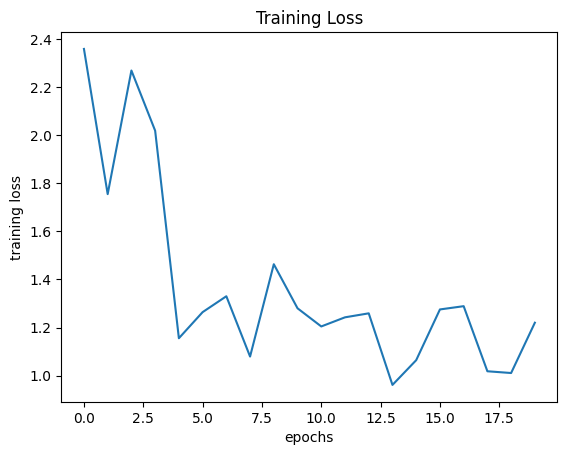

In [10]:
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(loss_graph)

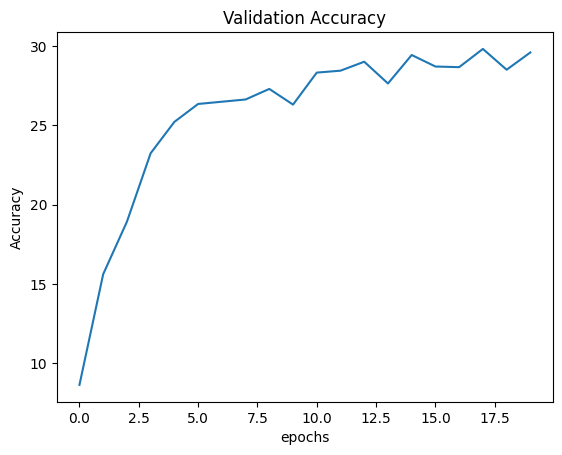

In [11]:
plt.title("Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(accuracy_graph)